In [160]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

np.random.seed(0)

## Utility functions

Some functions for plotting and random number generation.

In [102]:
def plot_contours(f, ax, **plot_kwargs):
    "Make a contour plot of a vectorized function on the given axes."

    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)

    points = np.stack([X.ravel(), Y.ravel()], axis=1)
    vals = f(points)
    Z = vals.reshape(X.shape)
    
    contours =  ax.contour(X, Y, Z, alpha=0.9, **plot_kwargs)
    ax.clabel(contours)

In [72]:
def plot_level_set(f, alpha, ax):
    "Plot the alpha-level set of a vectorized function on the given axes."

    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)

    points = np.stack([X.ravel(), Y.ravel()], axis=1)
    vals = f(points)
    Z = vals.reshape(X.shape)
    
    ax.contour(X, Y, Z, levels=[0., alpha], cmap='Blues', alpha=0.9)

In [73]:
def plot_func(f, ax, **plot_kwargs):
    "Plot a vectorized function on [-1, 1]."
    ts = np.linspace(-1, 1, 100)
    ax.plot(ts, f(ts), **plot_kwargs)

In [74]:
def sample_ball_unif(n_samples, rad, dim=2):
    "Sample uniformly from a Euclidean ball."
    x = np.random.randn(n_samples, dim)
    x /= np.linalg.norm(x, axis=1, keepdims=True)
    u = np.random.rand(n_samples, 1)
    r = rad * u ** (1.0 / dim)
    return r * x

## Computing the CD polynomial via np.solve:

In [161]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.linalg import solve_triangular


class CDPolynomial():

    def __init__(self, data, degree=2, eps=0.):
        """
        Initialize the CD polynomial based on data.
        Degree is the degree of the basis (half that of the moment matrix).
        We assume that the data points are represented by their coordinates in
        a basis - e.g. for a function space, the coordinates with respect to
        the Chebyshev basis. Eps is a regularization parameter which ensures
        that the moment matrix is nonsingular.
        """
        self.alg_deg = degree  # algebraic degree (highest deg of a monomial)
        _, self.harm_deg = data.shape  # harmonic degree (number of variables)

        poly = PolynomialFeatures(degree=degree).fit_transform(data)
        _, self.n_monomials = poly.shape
        self.moments = np.einsum('bi,bj->bij', poly, poly).mean(axis=0)
        self.moments += eps * np.eye(self.n_monomials, self.n_monomials)
        self.L = np.linalg.cholesky(self.moments)

    def __call__(self, z):
        """
        Evaluate the CD polynomial at a point (also represented by coords).
        """
        poly = PolynomialFeatures(degree=self.alg_deg).fit_transform(z)
        y = solve_triangular(self.L, poly.T, lower=True)  # (n_data, batch)
        z = solve_triangular(self.L.T, y, lower=False)  # (n_data, batch)
        return np.einsum('bi,ib->b', poly, z)

The following version uses np.solve instead of the Cholesky decomposition.

In [ ]:
class CDPolynomialSolve():

    def __init__(self, data, degree=2, eps=0.):
        """
        Initialize the CD polynomial based on data.
        We assume that the data points are represented by their coordinates in a basis -
        e.g. for a function space, the coordinates with respect to the Chebyshev basis.
        Eps is a regularization parameter which ensures that the moment matrix is nonsingular.
        """
        self.alg_deg = degree # algebraic degree (i.e. highest degree of a monomial)
        _, self.harm_deg = data.shape # harmonic degree (i.e. number of variables)

        poly = PolynomialFeatures(degree=degree).fit_transform(data)
        _, self.n_monomials = poly.shape
        self.moments = np.einsum('bi,bj->bij', poly, poly).mean(axis=0)
        self.moments += eps * np.eye(self.n_monomials, self.n_monomials)

    def __call__(self, z):
        """
        Evaluate the CD polynomial at a point (also represented by its coordinates).
        """
        poly = PolynomialFeatures(degree=self.alg_deg).fit_transform(z)
        return np.einsum('bi,ib->b', poly, np.linalg.solve(self.moments, poly.T))

## Gaussian example

In [162]:
mu = np.zeros(2)
sig = np.array([[1., .5,], [.5, 1.]])

z = multivariate_normal(mu, sig).rvs(100)

In [168]:
p = CDPolynomial(z, degree=3)

In [169]:
p(np.array([[1., 1.], [2.,  2.], [3., 3.]]))

array([  4.72098249,  58.01005246, 632.83761363])

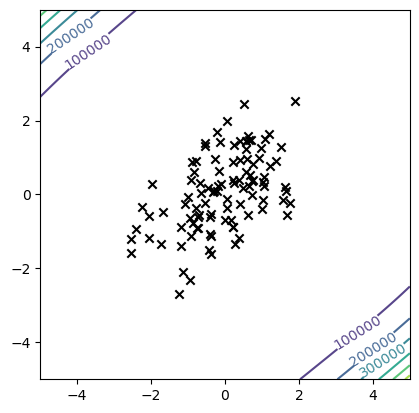

In [170]:
fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plot_contours(p, ax)
ax.scatter(*z.T, color='black', marker='x')
ax.set_aspect('equal')

In [166]:
sample_vals = p(z)
sample_vals.mean(), p.n_monomials # these should be almost equal, according to Lemma 3

(np.float64(3.0000000000000004), 3)

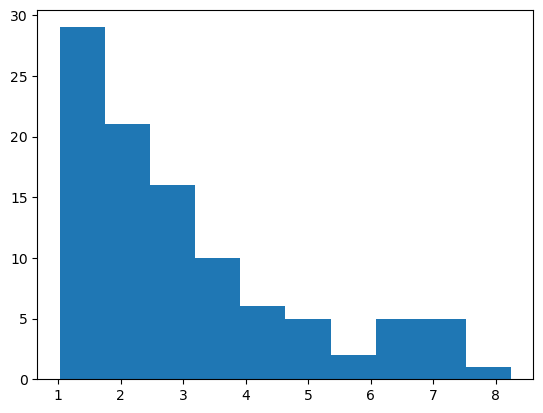

In [167]:
plt.hist(sample_vals);

In [110]:
idx_max = np.argmax(sample_vals)
print(f'Sample point with most extreme CD poly value: {z[idx_max]}')

Sample point with most extreme CD poly value: [0.72637791 2.79087077]


In [111]:
quantiles = [np.quantile(sample_vals, q=q) for q in [0., .25, .5, .75, 1.]]
quantiles

[np.float64(1.0073300874457225),
 np.float64(1.4980435061978925),
 np.float64(2.4836093327796087),
 np.float64(3.8702435785031004),
 np.float64(9.663478017205485)]

## Number of samples vs. total degree

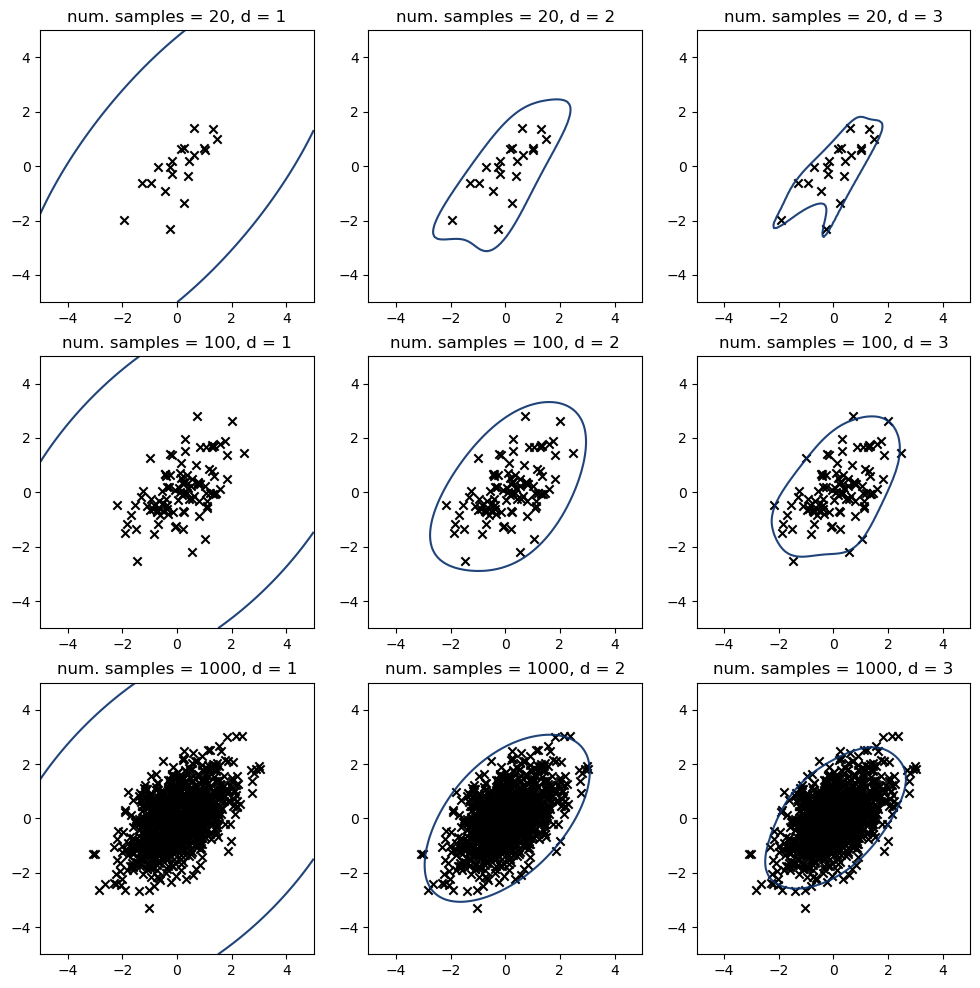

In [171]:
lim = 5
ns = [20, 100, 1_000]
ds = [1, 2, 3]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    z = multivariate_normal([0., 0.], [[1., .5], [.5, 1.]]).rvs(ns[i])
    for j in range(3):
        p = CDPolynomial(z, degree=ds[j])
        ax = axs[i, j]
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        plot_level_set(p, 50., ax)
        ax.scatter(*z.T, color='black', marker='x')
        ax.set_title(f'num. samples = {ns[i]}, d = {ds[j]}')

## Degree vs. Cutoff hyperparam

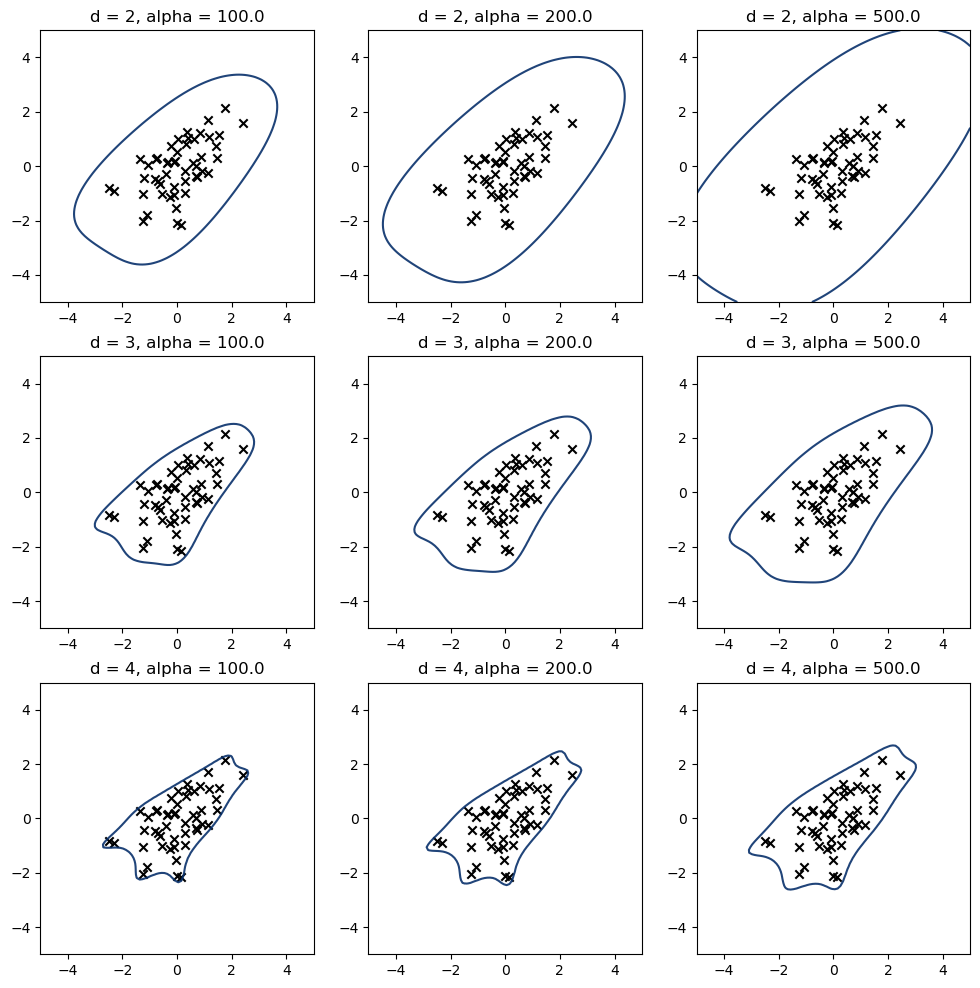

In [172]:
lim = 5
ds = [2, 3, 4]
cuts = [100., 200., 500.]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

z = multivariate_normal([0., 0.], [[1., .5], [.5, 1.]]).rvs(50)
for i in range(3):
    for j in range(3):
        p = CDPolynomial(z, degree=ds[i])
        ax = axs[i, j]
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        plot_level_set(p, cuts[j], ax)
        ax.scatter(*z.T, color='black', marker='x')
        ax.set_title(f'd = {ds[i]}, alpha = {cuts[j]}')

## Extending to the infinite-dimensional case: Chebyshev basis

In [174]:
from scipy.special import eval_chebyt

class Chebyshev():
    """
    A function represented by coordinates in the Chebyshev basis.
    """

    def __init__(self, coords):
        self.n_basis = len(coords)
        self.coords = coords

    def __call__(self, z):
        """
        Evaluate the function represented by these coordinates at z. Vectorized over z.
        """
        proj = np.column_stack([eval_chebyt(k, z) for k in range(self.n_basis)])
        return  proj @ self.coords
    
    def __add__(self, other):
        return Chebyshev(self.coords + other.coords)

In [152]:
const = 1 / 3
g0 = Chebyshev(np.array([0., const, const, const])) # reference function

In [175]:
def sample_funcs(n_funcs, noise=.1):
    "Sample functions on [-1, 1] using the Chebyshev basis."
    coords = sample_ball_unif(n_funcs, noise, dim=4)
    funcs = [g0 + Chebyshev(coord) for coord in coords]
    return funcs

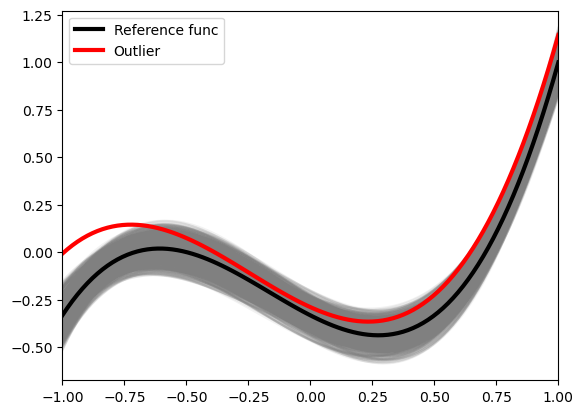

In [176]:
fig, ax = plt.subplots()

gs = sample_funcs(1_000)
for g in gs:
    plot_func(g, ax, color='grey', alpha=.1)

plot_func(g0, ax, label='Reference func', lw=3, color='black')

g_outlier = sample_funcs(1, noise=.2)[0]
plot_func(g_outlier, ax, label='Outlier', lw=3, color='red')

ax.set_xlim(-1, 1)
ax.legend()

In [177]:
gs_coords = np.stack([g.coords for g in gs])

p = CDPolynomial(gs_coords, degree=4, eps=0.)

In [178]:
p.alg_deg, p.harm_deg, p.n_monomials

(4, 4, 70)

In [179]:
sample_vals = p(gs_coords)

sample_vals.max()

np.float64(214.50405658523232)

In [180]:
# should be about equal, according to Lemma 3
# this will only be the case if the regularization param eps is set to zero
sample_vals.mean(), p.n_monomials 

(np.float64(70.00003968392986), 70)

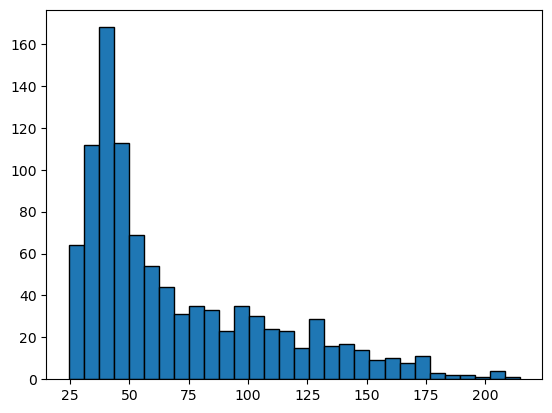

In [181]:
plt.hist(sample_vals, bins=30, edgecolor='black', lw=.5);

In [182]:
p(np.array([g_outlier.coords])) # as expected, much larger than for the sampled functions

array([86203.63052423])

## Gaussian mixture example

In [183]:
n = 100

mu1 = np.array([-2., 0])
sig1 = np.array([[.2, .0,], [.0, 2.]])
z1 = multivariate_normal(mu1, sig1).rvs(n // 2)

mu2 = np.array([2., 0])
sig2 = np.array([[2., .0,], [.0, .2]])
z2 = multivariate_normal(mu2, sig2).rvs(n // 2)

z = np.concatenate([z1, z2])

In [184]:
p = CDPolynomial(z, degree=2)

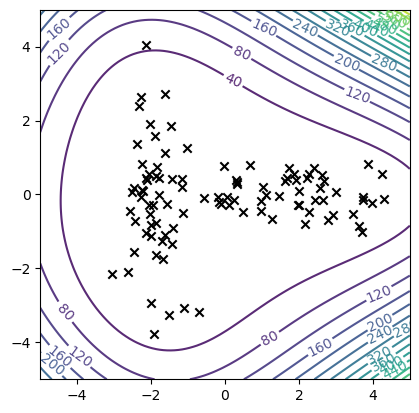

In [185]:
fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plot_contours(p, ax, levels=20)
ax.scatter(*z.T, color='black', marker='x')
ax.set_aspect('equal')

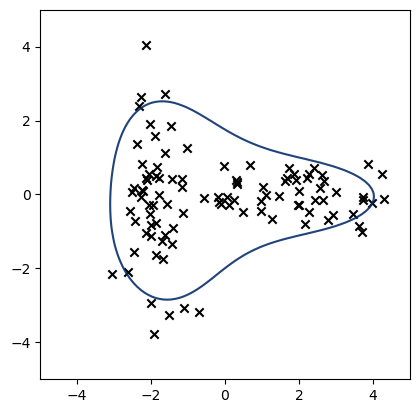

In [186]:
fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plot_level_set(p, 10., ax)
ax.scatter(*z.T, color='black', marker='x')
ax.set_aspect('equal')